마켓스미스에서는 rs line(지수대비상대강도선)을 이렇게 정의한다.

Relative Strength (RS) Line

The relative strength line compares a stock's price performance versus the S&P 500. Many charting services plot a RS Line along with the stock's price, moving averages, etc. The line is derived by dividing the stock price by the S&P 500 Index value. An upward sloping line means that the stock's price is outperforming the S&P 500 Index.

상대 강도(RS) 선

상대적 강세선은 S&P 500과의 주가 성과를 비교한다. 많은 차트 작성 서비스는 주가, 이동 평균 등과 함께 RS 라인을 표시합니다. 이 선은 주가를 S&P 500 지수 값으로 나눈 것이다. 상승 추세인 선은 그 주가가 S&P 500 지수를 능가하고 있다는 것을 의미한다.

번역: 파파고

다음 코드는 이것을 구현한 코드다.
나는 여기에서 S&P 500을 종합주가지수로 바꾸었다.

In [ ]:
import pandas as pd
import pymysql
import win32com.client
import datetime
from sqlalchemy import create_engine
import sqlalchemy as db
import ctypes
import time
import sys

cpOhlc = win32com.client.Dispatch('CpSysDib.StockChart')
objCpCodeMgr = win32com.client.Dispatch("CpUtil.CpCodeMgr")
instCpCodeMgr = win32com.client.Dispatch("CpUtil.CpCodeMgr")

In [ ]:
# 버전 확인, 크레온 플러스는 32비트에서만 돌아간다.
print("python version:", sys.version)
print("pandas version:", pd.__version__)
print("pymysql version:", pymysql.__version__)
print("ctypes version:", ctypes.__version__)

python version: 3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 12:57:03) [MSC v.1916 32 bit (Intel)]
pandas version: 1.1.5
pymysql version: 1.0.2
ctypes version: 1.1.0


In [ ]:
def get_ohlc(code, toDate, fromDate):   # 종목 코드와 반환할 개수
    cpOhlc.SetInputValue(0, code)           # 종목코드
    cpOhlc.SetInputValue(1, ord('1'))  # 기간으로 받기
    cpOhlc.SetInputValue(2, toDate)  # To 날짜
    cpOhlc.SetInputValue(3, fromDate)  # From 날짜
    cpOhlc.SetInputValue(5, [0, 2, 3, 4, 5, 8, 9]) # 0:날짜, 2~5:OHLC, volume, volume_amount
    cpOhlc.SetInputValue(6, ord('D'))        # 일단위
    cpOhlc.SetInputValue(9, ord('1'))        # 수정주가
    cpOhlc.BlockRequest()
    count = cpOhlc.GetHeaderValue(3)   
    columns = ['date', 'code', 'company', 'open', 'high', 'low', 'close', 'volume', 'volume_amount']
    index = []
    rows = []
    company_name = objCpCodeMgr.CodeToName(code)
    for i in range(count): 
        rows.append([str(cpOhlc.GetDataValue(0, i)),
                     code,
                     company_name,
                     cpOhlc.GetDataValue(1, i),
                     cpOhlc.GetDataValue(2, i),
                     cpOhlc.GetDataValue(3, i),
                     cpOhlc.GetDataValue(4, i),
                     cpOhlc.GetDataValue(5, i),
                     cpOhlc.GetDataValue(6, i)])
    df = pd.DataFrame(rows, columns=columns)
    df = df[::-1]
    df = df.reset_index(drop = True)
    df['date'] = pd.to_datetime(df['date'], format = "%Y%m%d") 
    return df

In [ ]:
# 코로나장의 rs line 시각화
fromDate, toDate = "20200531", "20200101"
data = get_ohlc('A011200', fromDate, toDate)   # hmm 데이터
index = get_ohlc('U001', fromDate, toDate)   # 종합주가지수

data['rs_line'] = data['close'] / index['close']  # rs line

아래의 그래프는 코로나장에서 말 그대로 빅 위너였던 hmm의 rs line이다.

지수가 급락할 때, hmm의 rs line을 보면 놀랍게도 조금 하락하는 것을 볼 수 있다.
심지어 초반 지수가 급락할 때 rs line은 완만하기까지 하다.
이후, hmm은 급등하기 시작한다.

이는 지수보다 hmm이 덜 하락했다는 뜻이고, 이는 기관 자금이 다른 종목보다 덜 빠져나갔다고 해석 가능하다.

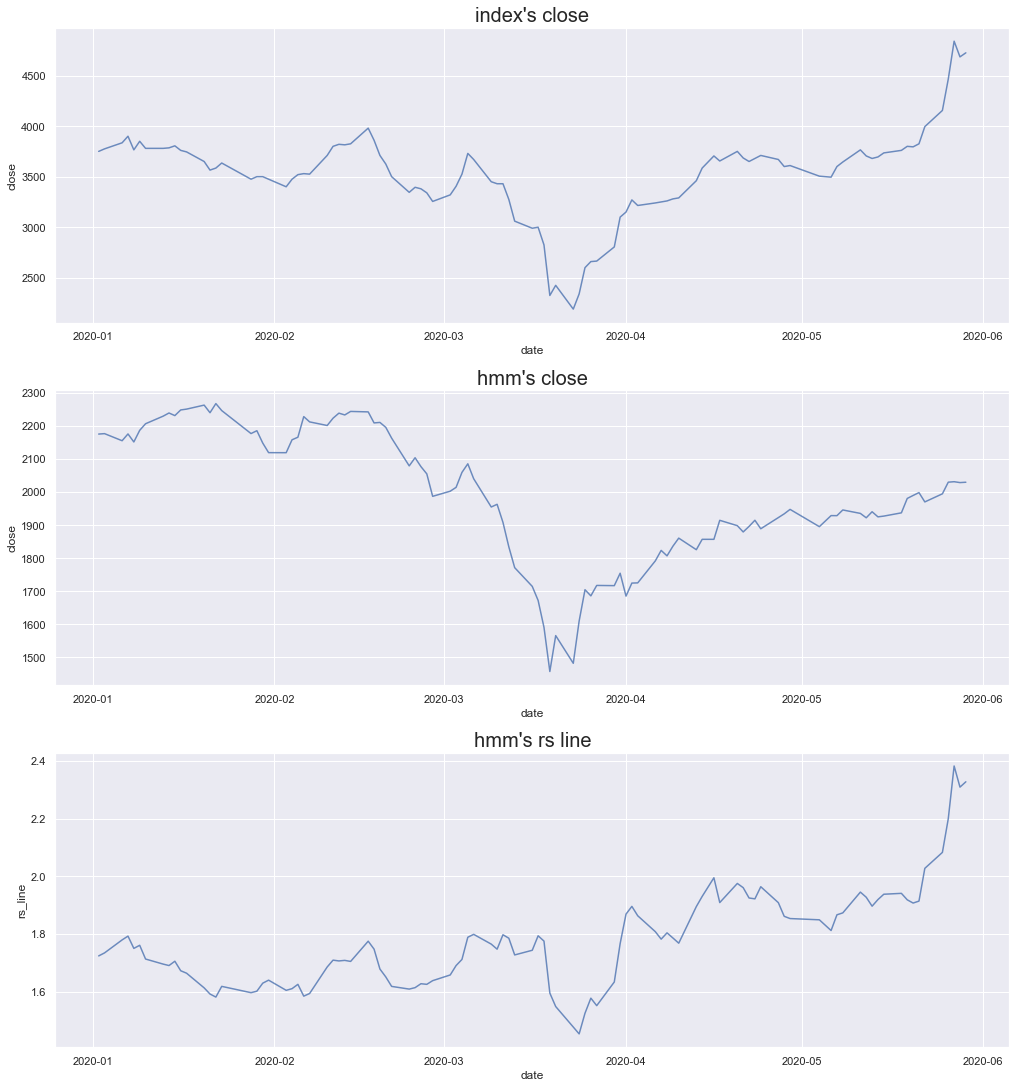

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={"axes.unicode_minus":False})

fig, ax = plt.subplots(nrows = 3, figsize = (14, 15), constrained_layout = True)

g = sns.lineplot(data=data, x='date', y='close', 
                alpha = .8, ax = ax[0])
g.set_title("index's close", fontsize = 20)

g = sns.lineplot(data=index, x='date', y='close', 
                alpha = .8, ax = ax[1])             
g.set_title("hmm's close", fontsize = 20)

g = sns.lineplot(data=data, x='date', y='rs_line', 
                alpha = .8, ax = ax[2])             
g.set_title("hmm's rs line", fontsize = 20)
plt.show()